### Final Modeling

#### About the Model: 

The following data pipeline and regression model predicts nickel price (price per ton??) for one and two years ahead of time based on 3 features: 

- 1) Nickel prices of 2 years prior to "today's" date
- 2) Current GDP growth rate percentage of China 
- 3) Current global nickel production (in ?? Units) 

#### Recommendations/Disclaimer: 
This model was created as an analytical/exploratory tool to build upon knowledge built from other tools as well. It would be extremely unrealistic to use this tool as a literal forecast and the methods used for final business decisions should be an integrative/cummulative one. 

#### Model Assumptions: 

The model assumes that there is a relationship between nickel price and previous nickel prices around that time. We realize there will be trends missed from behavior economic trends. 

Final model to include these features: 
- 



#### Performance Evaluation: 

- The model is built using data from the preceeding 15 years (, and is tested on the year after that's performance.  

FINAL MODEL: 
- Staggered over JUST 2 years
- over 15 years? 
- Features -- Global nickel production

NEXT STEPS to include:
- Fixing input data for global prod 
- Running model and evaluating results 
- Constructing CONFIDENCE INTERVALS OF RESULTS
- Final graphs of predictions


- OUTPUT CSV which includes timestamp of predictions 
- Check MAE over previous 3 years


### Additional Features: 

#### - df['week_of_year'] = df.index.weekofyear 
#### - df['day_of_month'] = df.index.day

#### - GDP per capita and GDP Growth - China https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=CN
#### - China consumption expenditure per GDP 
#### - Global production



In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import os

from sklearn.utils import resample
import numpy as np


In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)




### Preprocessing of nickel price (LME), nickel global production (USGS Annual Reports), China GDP per capita and growth (World Bank) 

- Nickel global production link: https://www.usgs.gov/centers/nmic/nickel-statistics-and-information
- GDP China link: https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=CN

In [3]:

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']

LME_futures = LME_futures.iloc[:, 1:]
#LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()

LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()

inventory = LME_futures.iloc[:, 1]
inventory = inventory.astype(float)
inventory = inventory.resample('B').mean()

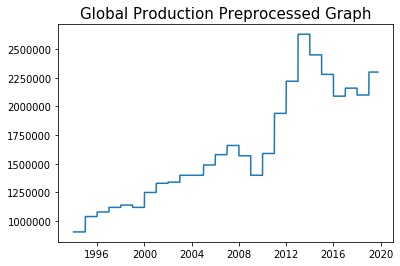

In [4]:
global_production = pd.read_excel('forecasting_raw_data/nickel_features/nickel_extracted.xlsx')
date_index = [datetime.datetime(year, 1, 1) for year in range(1994, 2021)]
series = list(global_production.iloc[:, 1])
series.append(np.nan)

global_production = pd.DataFrame({'global_prod': series})
global_production.index = date_index


global_production = global_production.resample('B').ffill()
upsampled_prod = global_production.interpolate(method='linear')

upsampled_prod = upsampled_prod.dropna()
upsampled_prod = upsampled_prod.loc[:LME.index[-1], :]

LME = LME[upsampled_prod.index]
plt.plot(upsampled_prod)
plt.title('Global Production Preprocessed Graph', fontsize=15)
plt.show()

In [5]:


china_gdp = pd.read_csv('forecasting_raw_data/nickel_features/china_gdp_by_quarter.csv')
china_gdp = china_gdp.set_index(pd.to_datetime(china_gdp['DATE']))
china_gdp = china_gdp.iloc[:, 1]

#china_gdp = china_gdp.reindex(LME.index)
china_gdp = china_gdp.resample('B').ffill()
upsampled = china_gdp.interpolate(method='linear')

upsampled.head()
#LME = LME[upsampled.index]


DATE
1992-01-01    5.262800e+11
1992-01-02    5.262800e+11
1992-01-03    5.262800e+11
1992-01-06    5.262800e+11
1992-01-07    5.262800e+11
Freq: B, Name: Current Price GDP China, dtype: float64

In [6]:
## Different version of China gdp

china_gdp_per_cap = pd.read_excel('forecasting_raw_data/nickel_features/china_gdp_summary.xlsx')
china_gdp_per_cap.columns = china_gdp_per_cap.iloc[0, :]

china_gdp_per_cap.iloc[1, 1990: ]

china_gdp_per_cap

,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
0,Country Name,Country Code,Indicator Name,Indicator Code,1960.000000,1961.000000,1962.000000,1963.000000,1964.000000,1965.000000,...,2010.000000,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.0
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.520542,75.805838,70.909412,74.313643,85.498555,98.486778,...,4550.453596,5618.132491,6316.918863,7050.645920,7651.366044,8033.388043,8078.790474,8759.041578,9770.847088,NaN
2,China,CHN,GDP per capita growth (annual %),NY.GDP.PCAP.KD.ZG,NaN,-26.527644,-6.351505,7.622254,15.468995,14.197889,...,10.103101,9.027256,7.335380,7.237863,6.757622,6.363469,6.160281,6.161772,6.115117,NaN


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [7]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [8]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled

LME_shifted = LME.shift(-261).dropna()


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [9]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
inventory_stationary=preprocess(inventory, window_setting)
upsampled_stationary = preprocess(upsampled, window_setting)
global_prod_stationary = preprocess(upsampled_prod, window_setting)


rcParams['figure.figsize'] = 9, 6

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df['lag11'] = df.lag0.shift(periods=11*lag_length)
df['lag12'] = df.lag0.shift(periods=13*lag_length)
df['lag13'] = df.lag0.shift(periods=15*lag_length)
df['lag14'] = df.lag0.shift(periods=17*lag_length)
df['lag15'] = df.lag0.shift(periods=19*lag_length)
df['lag16'] = df.lag0.shift(periods=21*lag_length)
df['lag17'] = df.lag0.shift(periods=23*lag_length)
'''
df['lag18'] = df.lag0.shift(periods=26*lag_length)
df['lag19'] = df.lag0.shift(periods=29*lag_length)
df['lag20'] = df.lag0.shift(periods=32*lag_length)

df['lag21'] = df.lag0.shift(periods=35*lag_length)
df['lag22'] = df.lag0.shift(periods=38*lag_length)
'''

df.index = df['ds']
df = df.iloc[:, 1:]
df['gdp'] = upsampled_stationary
df['global_prod'] = global_prod_stationary
df['week_of_year'] = df.index.weekofyear 
df['day_of_month'] = df.index.day


df['y'] = df['lag0'].shift(-261)
df = df.dropna(subset=['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'])

#df = df.dropna()
df.tail()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag13,lag14,lag15,lag16,lag17,gdp,global_prod,week_of_year,day_of_month,y
ds,,,,,,,,,,,,,,,,,,,,,
2019-10-01,-199.825,1990.075,865.850,503.7625,-144.525,-331.700,-132.5625,56.7375,270.800,397.600,...,147.9625,168.0625,808.450,63.325,710.975,NaN,0.0,40,1,NaN
2019-10-02,35.625,1828.125,608.975,743.2875,-189.275,-37.925,-177.9875,105.2125,467.200,473.325,...,367.1625,542.4875,1820.150,263.875,647.850,NaN,0.0,40,2,NaN
2019-10-03,189.375,1167.475,1557.275,829.7375,-164.225,32.825,-387.5875,-119.4375,355.200,510.975,...,194.5375,146.6875,1526.250,241.000,864.925,NaN,0.0,40,3,NaN
2019-10-04,307.375,1311.925,1087.725,1100.6875,-112.525,-141.575,-371.4375,-134.1875,441.250,659.275,...,141.7875,9.6125,1187.525,170.775,1213.175,NaN,0.0,40,4,NaN
2019-10-07,203.225,1559.425,1149.550,1205.3125,-206.025,-140.275,-355.6875,-165.5625,371.325,450.275,...,-132.4875,-227.3375,525.850,322.050,1139.375,NaN,0.0,41,7,NaN


### Splitting up Training/Testing by Day

- Train multiple models on 261*16=4176 days versus Tests of 261 AND 522 days (1 and 2 years)

How to normalize/standardize: 
https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

### GOAL: To run tests over last 10??? years to take a closer look at MAE's over different sliding windows -- To get a sense of the long term accuracy of the model - scenario evaluation

In [10]:
dates = df.index

In [11]:
np.sqrt(261*15)

62.56996084384263

In [12]:
df.index

DatetimeIndex(['1995-11-06', '1995-11-07', '1995-11-08', '1995-11-09',
               '1995-11-10', '1995-11-13', '1995-11-14', '1995-11-15',
               '1995-11-16', '1995-11-17',
               ...
               '2019-09-24', '2019-09-25', '2019-09-26', '2019-09-27',
               '2019-09-30', '2019-10-01', '2019-10-02', '2019-10-03',
               '2019-10-04', '2019-10-07'],
              dtype='datetime64[ns]', name='ds', length=6241, freq=None)

In [ ]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2003, 10, 2)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    
    X_train = train[['week_of_year', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['week_of_year', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2010-11-09 00:00:00 , Optimal K: 27 , MAE: 2181.598107643594
2010-11-10 00:00:00 , Optimal K: 27 , MAE: 2115.4424595517826
2010-11-11 00:00:00 , Optimal K: 27 , MAE: 2080.3915115940395
2010-11-12 00:00:00 , Optimal K: 27 , MAE: 2037.370125483634
2010-11-15 00:00:00 , Optimal K: 27 , MAE: 1982.4841966430615
2010-11-16 00:00:00 , Optimal K: 27 , MAE: 1922.0544670216295
2010-11-17 00:00:00 , Optimal K: 27 , MAE: 1911.598478187182
2010-11-18 00:00:00 , Optimal K: 27 , MAE: 1883.8528675952657
2010-11-19 00:00:00 , Optimal K: 27 , MAE: 1832.6973495882582
2010-11-22 00:00:00 , Optimal K: 27 , MAE: 1810.470829540244
2010-11-23 00:00:00 , Optimal K: 27 , MAE: 1784.7927057938598
2010-11-24 00:00:00 , Optimal K: 27 , MAE: 1748.783985387754
2010-11-25 00:00:00 , Optimal K: 27 , MAE: 1721.3729335089163
2010-11-26 00:00:00 , Optimal K: 27 , MAE: 1697.8550927432946
2010-11-29 00:00:00 , Optimal K: 27 , MAE: 1691.0255055686655
2010-11-30 00:00:00 , Optimal K: 27 , MAE: 1669.4763380696538
2010-12-01 00

2011-05-16 00:00:00 , Optimal K: 51 , MAE: 1548.6043925529293
2011-05-17 00:00:00 , Optimal K: 51 , MAE: 1504.2802957992792
2011-05-18 00:00:00 , Optimal K: 51 , MAE: 1476.9264468122706
2011-05-19 00:00:00 , Optimal K: 51 , MAE: 1465.8658311227905
2011-05-20 00:00:00 , Optimal K: 51 , MAE: 1437.3236441789309
2011-05-23 00:00:00 , Optimal K: 51 , MAE: 1439.8453148996994
2011-05-24 00:00:00 , Optimal K: 51 , MAE: 1429.3606513977184
2011-05-25 00:00:00 , Optimal K: 51 , MAE: 1412.2222018921736
2011-05-26 00:00:00 , Optimal K: 53 , MAE: 1417.5967757893332
2011-05-27 00:00:00 , Optimal K: 51 , MAE: 1427.802003633772
2011-05-30 00:00:00 , Optimal K: 51 , MAE: 1429.8829702804228
2011-05-31 00:00:00 , Optimal K: 51 , MAE: 1420.3775724389998
2011-06-01 00:00:00 , Optimal K: 51 , MAE: 1404.6137211049534
2011-06-02 00:00:00 , Optimal K: 51 , MAE: 1393.3802174534185
2011-06-03 00:00:00 , Optimal K: 51 , MAE: 1376.7370047280406
2011-06-06 00:00:00 , Optimal K: 51 , MAE: 1368.7686029825807
2011-06-0

2011-11-17 00:00:00 , Optimal K: 55 , MAE: 3294.8182246733527
2011-11-18 00:00:00 , Optimal K: 55 , MAE: 3319.8318521287833
2011-11-21 00:00:00 , Optimal K: 55 , MAE: 3376.8857114451876
2011-11-22 00:00:00 , Optimal K: 53 , MAE: 3437.321721769115
2011-11-23 00:00:00 , Optimal K: 55 , MAE: 3515.2446259245835
2011-11-24 00:00:00 , Optimal K: 55 , MAE: 3579.649212794126
2011-11-25 00:00:00 , Optimal K: 35 , MAE: 3639.92366548096
2011-11-28 00:00:00 , Optimal K: 35 , MAE: 3674.987842127105
2011-11-29 00:00:00 , Optimal K: 35 , MAE: 3755.496271234289
2011-11-30 00:00:00 , Optimal K: 53 , MAE: 3834.762856978961
2011-12-01 00:00:00 , Optimal K: 55 , MAE: 3931.2780878455974
2011-12-02 00:00:00 , Optimal K: 55 , MAE: 4053.759037657767
2011-12-05 00:00:00 , Optimal K: 55 , MAE: 4189.0238902883475
2011-12-06 00:00:00 , Optimal K: 55 , MAE: 4300.595868534652
2011-12-07 00:00:00 , Optimal K: 55 , MAE: 4410.852327548181
2011-12-08 00:00:00 , Optimal K: 55 , MAE: 4458.940613557747
2011-12-09 00:00:00

2012-05-24 00:00:00 , Optimal K: 59 , MAE: 2628.0422832910526
2012-05-25 00:00:00 , Optimal K: 59 , MAE: 2644.6753947938346
2012-05-28 00:00:00 , Optimal K: 59 , MAE: 2629.8196292878506
2012-05-29 00:00:00 , Optimal K: 59 , MAE: 2639.641622471352
2012-05-30 00:00:00 , Optimal K: 59 , MAE: 2660.657390344817
2012-05-31 00:00:00 , Optimal K: 59 , MAE: 2671.368245235715
2012-06-01 00:00:00 , Optimal K: 59 , MAE: 2680.637347336632
2012-06-04 00:00:00 , Optimal K: 59 , MAE: 2713.653049062672
2012-06-05 00:00:00 , Optimal K: 59 , MAE: 2744.907527070694
2012-06-06 00:00:00 , Optimal K: 59 , MAE: 2760.2819643142266
2012-06-07 00:00:00 , Optimal K: 59 , MAE: 2772.5250924646816
2012-06-08 00:00:00 , Optimal K: 59 , MAE: 2800.808351111393
2012-06-11 00:00:00 , Optimal K: 59 , MAE: 2804.936569439546
2012-06-12 00:00:00 , Optimal K: 59 , MAE: 2756.7789914506907
2012-06-13 00:00:00 , Optimal K: 57 , MAE: 2694.868436623573
2012-06-14 00:00:00 , Optimal K: 59 , MAE: 2593.534648101698
2012-06-15 00:00:0

2012-11-27 00:00:00 , Optimal K: 59 , MAE: 1610.496864651201
2012-11-28 00:00:00 , Optimal K: 59 , MAE: 1571.804366619503
2012-11-29 00:00:00 , Optimal K: 59 , MAE: 1540.6283677274807
2012-11-30 00:00:00 , Optimal K: 59 , MAE: 1521.2870575924771
2012-12-03 00:00:00 , Optimal K: 59 , MAE: 1510.1382625707615
2012-12-04 00:00:00 , Optimal K: 59 , MAE: 1507.8892186378134
2012-12-05 00:00:00 , Optimal K: 59 , MAE: 1515.970239552627
2012-12-06 00:00:00 , Optimal K: 59 , MAE: 1526.4545704160937
2012-12-07 00:00:00 , Optimal K: 59 , MAE: 1547.986387255331
2012-12-10 00:00:00 , Optimal K: 59 , MAE: 1575.0874202355128
2012-12-11 00:00:00 , Optimal K: 59 , MAE: 1601.5048106453387
2012-12-12 00:00:00 , Optimal K: 59 , MAE: 1628.9385849765874
2012-12-13 00:00:00 , Optimal K: 59 , MAE: 1635.2741603652025
2012-12-14 00:00:00 , Optimal K: 59 , MAE: 1657.5889657243995
2012-12-17 00:00:00 , Optimal K: 59 , MAE: 1671.8583000230128
2012-12-18 00:00:00 , Optimal K: 59 , MAE: 1684.825606238299
2012-12-19 00

2013-06-03 00:00:00 , Optimal K: 59 , MAE: 6562.870473571767
2013-06-04 00:00:00 , Optimal K: 1 , MAE: 6463.089688124463
2013-06-05 00:00:00 , Optimal K: 1 , MAE: 6353.841077542083
2013-06-06 00:00:00 , Optimal K: 1 , MAE: 6392.983627108349
2013-06-07 00:00:00 , Optimal K: 1 , MAE: 6389.744528272663
2013-06-10 00:00:00 , Optimal K: 1 , MAE: 6439.056289839416
2013-06-11 00:00:00 , Optimal K: 1 , MAE: 6286.100206908816
2013-06-12 00:00:00 , Optimal K: 1 , MAE: 5526.430421366334
2013-06-13 00:00:00 , Optimal K: 1 , MAE: 5477.368821813222
2013-06-14 00:00:00 , Optimal K: 1 , MAE: 5596.50179374957
2013-06-17 00:00:00 , Optimal K: 1 , MAE: 5865.1196889884395
2013-06-18 00:00:00 , Optimal K: 1 , MAE: 5968.130945161955
2013-06-19 00:00:00 , Optimal K: 1 , MAE: 5797.5721342385705
2013-06-20 00:00:00 , Optimal K: 1 , MAE: 5772.326278610439
2013-06-21 00:00:00 , Optimal K: 1 , MAE: 5777.899680084709
2013-06-24 00:00:00 , Optimal K: 1 , MAE: 5820.984777409049
2013-06-25 00:00:00 , Optimal K: 1 , M

2013-12-11 00:00:00 , Optimal K: 5 , MAE: 4670.487855975038
2013-12-12 00:00:00 , Optimal K: 5 , MAE: 4432.983294776945
2013-12-13 00:00:00 , Optimal K: 5 , MAE: 4474.654376348932
2013-12-16 00:00:00 , Optimal K: 5 , MAE: 4478.391639537755
2013-12-17 00:00:00 , Optimal K: 5 , MAE: 4386.308635688006
2013-12-18 00:00:00 , Optimal K: 5 , MAE: 4278.74111900807
2013-12-19 00:00:00 , Optimal K: 5 , MAE: 4246.544119394842
2013-12-20 00:00:00 , Optimal K: 5 , MAE: 4171.785739376288
2013-12-23 00:00:00 , Optimal K: 5 , MAE: 4145.477869318767
2013-12-24 00:00:00 , Optimal K: 5 , MAE: 4066.116997935652
2013-12-25 00:00:00 , Optimal K: 5 , MAE: 4039.6114755526382
2013-12-26 00:00:00 , Optimal K: 5 , MAE: 3926.489296316528
2013-12-27 00:00:00 , Optimal K: 5 , MAE: 3790.319010976368
2013-12-30 00:00:00 , Optimal K: 5 , MAE: 3758.9282517342754
2013-12-31 00:00:00 , Optimal K: 3 , MAE: 3619.5083812422718
2014-01-01 00:00:00 , Optimal K: 3 , MAE: 3383.348320735454
2014-01-02 00:00:00 , Optimal K: 3 , M

In [72]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_weekofmonth_15yrtrain.csv')

In [ ]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2003, 10, 2)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    
    X_train = train[['week_of_year', 'day_of_month', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['week_of_year', 'day_of_month', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

In [ ]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_weeksdays_ofmonth_15yrtrain.csv')

### To Get a Sense of How Well Model Will Do.....

Take a look at previous error rates over the last few years

In [ ]:
# Plot

## Final Model Used + Confidence Intervals: 

### TESTING PERIOD (how to organize X_test values) 
Uses LAST 261 days until NOW for X_train values/dates (which has y values of NOW++), which have no y_values yet

### Bootstrap is a way to estimate the confidence in the mean of a collection of numbers
### Perform a bootstrap for the mean -- 

STEPS: 
1. Take a random sample of data with replacement
2. Calculate the mean of the sample
3. Repeat this process many times (100x)
4. Calculate the percentiles of the result (usually 2.5 and 97.5) -- which represent the variability of the mean



In [60]:
a = np.array([[10, 7, 4], [1, 2, 3]])

print(np.percentile(a, 50))



3.5


In [55]:
# Set up of test set - Separate all values with the dates associated with NaN y values
test = df[df['y'].isna() == True]
test.head()

test.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag12,lag13,lag14,lag15,lag16,lag17,global_prod,week_of_year,day_of_month,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-10-08,-34.025,-745.950,-132.4875,-872.90,-227.3375,560.7625,525.850,-620.375,322.050,1021.4625,...,131.75,296.850,22.4125,-576.200,469.5750,-915.5875,0.0,41,8,NaN
2018-10-09,394.900,-870.900,-253.6625,-985.40,-567.0375,655.2625,176.150,-527.075,234.850,509.4625,...,220.90,145.725,-141.6375,-487.375,334.5500,-943.8125,0.0,41,9,NaN
2018-10-10,26.375,-411.125,-824.9125,-800.75,-232.2375,485.3125,289.900,-351.600,156.825,714.1875,...,347.60,525.450,69.0125,-545.500,331.2000,-548.2375,0.0,41,10,NaN
2018-10-11,20.825,-416.600,-310.1375,-1002.05,-235.2875,710.9875,335.175,-146.475,-183.875,1060.2500,...,635.05,434.200,89.2625,-397.100,42.8875,-411.8875,0.0,41,11,NaN
2018-10-12,-5.400,-334.950,-149.1875,-731.25,37.1125,558.8875,-61.725,-138.525,-165.200,426.6000,...,896.85,630.925,154.4125,-241.800,234.4250,-420.7875,0.0,41,12,NaN


In [56]:
# Set up of train set

# For now, pretend like the "current day" is 2019-01-01
today = datetime.datetime(2019, 1, 1)

train_offset = pd.tseries.offsets.BusinessDay(n= 15*261)
start_date = today-train_offset
end_date = test.index[0]-pd.tseries.offsets.BusinessDay(n=1)

print(start_date)
print(end_date)

#start_date_test = df[df['y'].isna() == True].index[0]
#test_offset = pd.tseries.offsets.BusinessDay(n=261)
#end_date_test = start_date_test+test_offset

train = df.loc[start_date:end_date, :]    
train

2003-12-30 00:00:00
2018-10-05 00:00:00


,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag12,lag13,lag14,lag15,lag16,lag17,global_prod,week_of_year,day_of_month,y
ds,,,,,,,,,,,,,,,,,,,,,
2003-12-30,2392.5050,504.8000,1080.2000,606.8750,126.7750,97.1250,220.270,-134.5250,98.1500,-52.8250,...,-77.6400,293.1500,214.6000,175.8500,-503.8500,195.1000,0.0,1,30,1545.075
2003-12-31,2185.9050,698.8000,550.8500,629.5250,123.2750,132.0750,201.470,-84.9250,258.7500,-162.5500,...,-60.9900,536.9000,314.8500,167.8000,-325.8750,192.4000,0.0,1,31,1522.575
2004-01-01,1997.1550,533.7000,650.7500,680.3250,237.0250,287.7250,72.320,-85.5750,511.3500,-134.6500,...,266.6600,299.4500,257.6750,220.9000,-269.2250,189.5000,0.0,1,1,1055.125
2004-01-02,2140.6050,591.9500,649.2750,685.5500,141.4250,194.6250,217.820,-377.3750,298.6750,-104.6250,...,239.1100,294.5500,117.2750,98.2500,-235.2500,155.8000,0.0,1,2,960.375
2004-01-05,2196.8550,688.1000,327.0000,985.0250,161.3500,311.3000,94.420,-624.7250,268.2250,-95.9250,...,340.5225,315.2000,-221.9750,-173.4500,-247.7500,129.3500,0.0,2,5,186.025
2004-01-06,84.6550,922.1000,637.0000,617.4750,122.0500,640.8500,154.470,-532.9750,439.1750,32.2250,...,472.0350,112.5750,-143.8250,-576.4750,-92.8500,240.1500,0.0,2,6,350.325
2004-01-07,6.0050,922.1000,765.6500,578.7750,246.0000,479.0000,109.820,-480.4250,442.6750,60.3750,...,646.5850,77.0250,-184.8250,-608.2250,-86.1750,166.0000,0.0,2,7,392.175
2004-01-08,741.9050,718.0000,577.2000,490.3750,370.1500,411.3500,294.470,-423.0250,657.1750,204.4250,...,705.7100,-24.1000,-197.0250,-607.2000,-173.4250,257.7500,0.0,2,8,833.325
2004-01-09,606.1850,1027.3700,872.8500,280.6250,374.9000,344.7000,591.370,-320.4750,605.0250,42.2750,...,570.3850,-111.4500,-133.2500,-677.2500,130.1250,132.8500,0.0,2,9,606.025


In [57]:

#test = df.loc[start_date_test:end_date_test, :]




X_train = train[['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
X_test = test[['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

y_train = train['y']
y_test = test['y']

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)


cv_results={}


for K in range(0, 60, 2):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    #rint()
    #rint('K: ', K)

    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
    
    '''
    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index

    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(K)] = mae

    

cv_results_series = pd.Series(list(cv_results.values()))
cv_results_series.index = cv_results.keys()
min_test_accuracy = cv_results_series.min()
min_parameters = cv_results_series.idxmin()
    '''

ds
2018-10-08    17534.786229
2018-10-09    17541.409862
2018-10-10    17574.645398
2018-10-11    17494.281269
2018-10-12    17537.562706
2018-10-15    17564.122197
2018-10-16    17631.015595
2018-10-17    17674.201332
2018-10-18    17852.590636
2018-10-19    17178.460634
2018-10-22    17834.034937
2018-10-23    17630.692828
2018-10-24    17422.425986
2018-10-25    17090.162540
2018-10-26    17004.528506
2018-10-29    17256.064889
2018-10-30    17714.567286
2018-10-31    17555.436540
2018-11-01    17812.865570
2018-11-02    17492.100374
2018-11-05    17350.381452
2018-11-06    16930.917569
2018-11-07    17245.440200
2018-11-08    17396.596678
2018-11-09    17844.675796
2018-11-12    17497.611747
2018-11-13    17850.273936
2018-11-14    17684.969904
2018-11-15    18285.868714
2018-11-16    18150.118847
dtype: float64

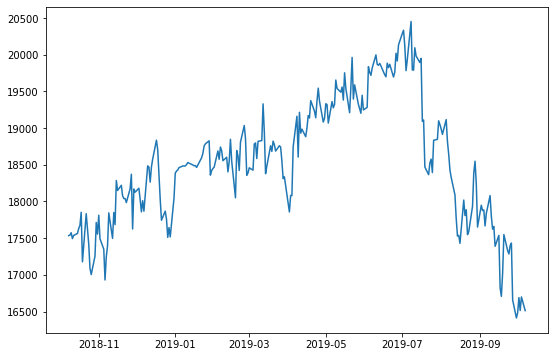

In [58]:
plt.plot(unscaled)
#plt.gridlines(True)
unscaled.head(30)

In [59]:
y_pred = unscaled

print(y_pred)


#y_lower = np.percentile(y_pred, 10)

#print(y_lower)
#y_higher = np.percentile(y_Pred, 90)
#y_mid = np.percentile(y_pred, 50)

ds
2018-10-08    17534.786229
2018-10-09    17541.409862
2018-10-10    17574.645398
2018-10-11    17494.281269
2018-10-12    17537.562706
2018-10-15    17564.122197
2018-10-16    17631.015595
2018-10-17    17674.201332
2018-10-18    17852.590636
2018-10-19    17178.460634
2018-10-22    17834.034937
2018-10-23    17630.692828
2018-10-24    17422.425986
2018-10-25    17090.162540
2018-10-26    17004.528506
2018-10-29    17256.064889
2018-10-30    17714.567286
2018-10-31    17555.436540
2018-11-01    17812.865570
2018-11-02    17492.100374
2018-11-05    17350.381452
2018-11-06    16930.917569
2018-11-07    17245.440200
2018-11-08    17396.596678
2018-11-09    17844.675796
2018-11-12    17497.611747
2018-11-13    17850.273936
2018-11-14    17684.969904
2018-11-15    18285.868714
2018-11-16    18150.118847
                  ...     
2019-08-27    18386.798281
2019-08-28    18548.640353
2019-08-29    18242.916031
2019-08-30    17652.135329
2019-09-02    17949.180479
2019-09-03    17876.24239

In [39]:
# Confidence Interval Time Series From tutorial https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/validating-and-inspecting-time-series-models?ex=12

# Bootstrapping TUtorial Statistics
# https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/bootstrap-confidence-intervals?ex=5

n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
# Compute the percentiles of choice for the bootstrapped means
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)

#conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})
conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})


In [44]:
print(bootstrap_means)

[[18456.84378109 18456.84378109 18456.84378109 ... 18456.84378109
  18456.84378109 18456.84378109]
 [18461.94082895 18461.94082895 18461.94082895 ... 18461.94082895
  18461.94082895 18461.94082895]
 [18590.67147797 18590.67147797 18590.67147797 ... 18590.67147797
  18590.67147797 18590.67147797]
 ...
 [18459.25407789 18459.25407789 18459.25407789 ... 18459.25407789
  18459.25407789 18459.25407789]
 [18529.62445989 18529.62445989 18529.62445989 ... 18529.62445989
  18529.62445989 18529.62445989]
 [18570.15957174 18570.15957174 18570.15957174 ... 18570.15957174
  18570.15957174 18570.15957174]]


In [37]:
n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
    print('random sample: ', random_sample)
    print()
    print('calculated mean', random_sample.mean(axis=0))
    print()

random sample:  ds
2018-11-28    17625.593422
2019-02-27    18356.570512
2019-01-29    18358.778301
2019-02-25    19034.772323
2018-12-31    18046.456536
2019-09-20    17549.608819
2018-12-13    18468.833320
2019-07-10    19789.626166
2018-11-29    18170.158469
2019-08-22    17548.826393
2019-05-30    19447.173936
2019-08-21    17887.554343
2019-09-09    18080.648368
2019-03-15    18480.482787
2018-10-11    17494.281269
2019-02-12    18403.477579
2019-02-11    18602.477223
2019-06-28    20132.671710
2018-12-06    18010.799320
2019-03-29    18336.212843
2019-05-02    19321.039420
2019-02-07    18691.143417
2019-06-06    19718.558893
2019-05-23    19395.219011
2019-09-23    17331.690037
2019-04-29    19082.124611
2019-01-25    18784.746840
2019-02-12    18403.477579
2019-02-26    18858.522699
2019-09-16    17538.842278
                  ...     
2019-06-05    19759.973145
2018-11-12    17497.611747
2019-04-17    19170.780500
2019-06-11    19867.582422
2019-09-24    17284.894348
2019-06-2


random sample:  ds
2019-07-12    19982.504484
2019-07-25    18394.101326
2019-04-12    18985.278629
2019-01-15    18497.854885
2019-03-26    18742.749200
2019-03-14    18378.962986
2019-02-19    18694.148427
2019-07-01    20287.408751
2019-07-09    19792.634979
2019-09-30    16413.433836
2019-09-13    17389.691705
2019-08-14    17528.843131
2019-08-16    17430.142103
2019-03-29    18336.212843
2018-12-03    18180.276105
2019-09-12    17660.225321
2018-10-10    17574.645398
2018-11-27    18371.351862
2019-01-29    18358.778301
2019-01-21    18563.399146
2019-07-08    20452.302151
2019-07-29    18847.099827
2019-05-13    19488.879305
2019-07-25    18394.101326
2019-01-04    18461.616093
2018-10-30    17714.567286
2019-04-15    18882.258251
2018-11-08    17396.596678
2018-12-04    18029.378041
2019-07-29    18847.099827
                  ...     
2019-06-04    19836.085132
2019-01-24    18755.643119
2019-09-10    17798.327390
2019-08-05    19115.069366
2018-10-23    17630.692828
2018-10-

In [35]:
bootstrap_means = np.zeros((n_boots, len(y_pred)))
bootstrap_means.shape

(100, 261)

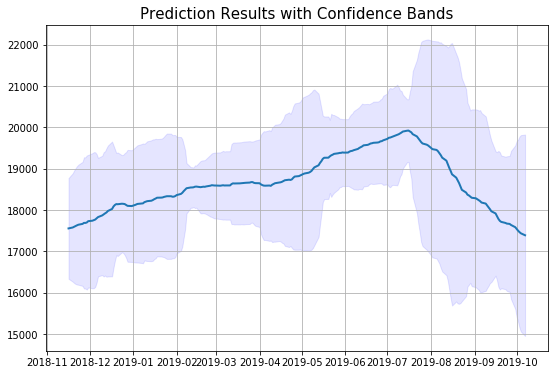

In [25]:
# From https://stackoverflow.com/questions/50161140/how-to-plot-a-time-series-array-with-confidence-intervals-displayed-in-python

time_series_df = pd.DataFrame(y_pred)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.show()

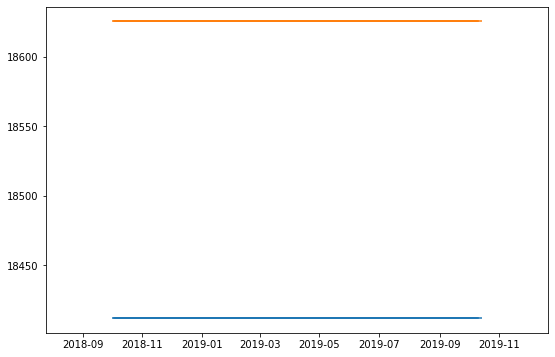

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_pred.index, percentiles[0], marker='_', s=200)
ax.scatter(y_pred.index, percentiles[1], marker='_', s=200)

In [30]:
def my_corrcoef(est, X, y):
    """Return the correlation coefficient
    between model predictions and a validation set."""
    return np.corrcoef(y, est.predict(X))[1, 0]
# Grab the date of the first index of each validation set
first_indices = [data.index[tt[0]] for tr, tt in cv.split(X, y)]
# Calculate the CV scores and convert to a Pandas Series
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=my_corrcoef)
cv_scores = pd.Series(cv_scores, index=first_indices)



fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
cv_scores_mean = cv_scores.rolling(10, min_periods=1).mean()
cv_scores.plot(ax=axs[0])
axs[0].set(title='Validation scores (correlation)', ylim=[0, 1])
# Plot the raw data
data.plot(ax=axs[1])
axs[1].set(title='Validation data')

NameError: name 'cv' is not defined

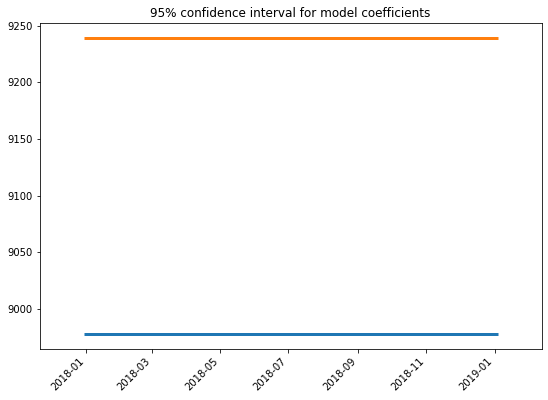

In [93]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(y_pred)

# Plot it
fig, ax = plt.subplots()
ax.scatter(y_pred.index, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(y_pred.index, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
y_pred

for i in range(100)

In [ ]:
# bootstrap for mean
boot_means = []
for _ in range(100):
    bootsample = np.random.choice(sample,size=30, replace=True)
    boot_means.append(bootsample.mean())